In [1]:
#---Step 0: Import necessary libraries---

# Use coinmarketcappy to get historical data on total market cap https://pypi.org/project/coinmarketcappy/
import coinmarketcappy as cmc
from cryptocmd import CmcScraper
import pandas as pd 
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
import csv
% matplotlib inline

# Plot styles
plt.style.use('seaborn-poster')
plt.style.use('fivethirtyeight')
plt.rcParams['axes.edgecolor'] = '#ffffff'
plt.rcParams['axes.facecolor'] = '#ffffff'
plt.rcParams['figure.facecolor'] = '#ffffff'
plt.rcParams['patch.edgecolor'] = '#ffffff'
plt.rcParams['patch.facecolor'] = '#ffffff'
plt.rcParams['savefig.edgecolor'] = '#ffffff'
plt.rcParams['savefig.facecolor'] = '#ffffff'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
#---Step 1: Generate Daily Total Market Capitalization---

# Generate total market cap (including Bitcoin)
market_cap = cmc.total_market_cap(exclude_btc=False)

# Create dictionary for holding dates and market cap
market_cap_dict = {"Date":[], "Market Cap": []}

# Loop through values and populate dictionary
for value in market_cap['market_cap_by_available_supply']:
    market_cap_dict['Date'].append(value[0])
    market_cap_dict['Market Cap'].append(value[1])

# Pass dictionary into dataframe, clean up date format, and set date as index
market_cap_df = pd.DataFrame(market_cap_dict)
market_cap_df["Date"] = pd.to_datetime(market_cap_df["Date"]).dt.date
market_cap_df = market_cap_df.set_index("Date")

In [3]:
#---Step 2: Generate Daily Market Capitalization by Coin---

# Read in CSV file containing historical data for every coin on CMC
# CSV file is generated using cryptomarketcap-historical-prices python scraper
df = pd.read_csv('/Users/cheon/HistoricalCoinData.csv')
df['Close**'] = pd.to_numeric(df['Close**'], errors='coerce')
df['Market Cap'] = pd.to_numeric(df['Market Cap'].str.replace(',',''), errors='coerce')
df['Date'] = pd.to_datetime(df['Date'].str.replace('No data was found for the selected time period.',''), errors='coerce')

# Pivot dataframe table to display date as index and coins as column headers
# Only display data after February 1st, 2018
df_pivot = df[df['Date'] >= '2018-02-01'].pivot(index='Date', columns='Coin', values='Market Cap').sort_index()

C:\Users\cheon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#---Step 3: Include Coins with at Least 120 Days of Historical Data---

# Create table for existing coins sorted by market cap (coins for which we have data today)
current_date = "2018-08-15"
marketcap_coins = pd.DataFrame(df[df["Date"]==current_date].set_index("Coin")["Market Cap"]).sort_values(by="Market Cap", ascending=False)

# Create list of coin names that have >=120 days of data
longer_than_120_coins = []

for coin in df_pivot.count().index:
    if df_pivot.count()[coin] > 120:
        longer_than_120_coins.append(coin)

In [5]:
#---Step 4: Filter Top 100 Coins with at Least 120 Days of Historical Data Based on Market Cap---

# List of coins names and associated market cap based on having at least 120 days of data
marketcap_coins_longer_120 = marketcap_coins[marketcap_coins.index.isin(longer_than_120_coins)]

# Create list of top 100 coin names with at least 120 days worth of data
top_100_coins = []

for i in range(0,100):
    top_100_coins.append(marketcap_coins_longer_120.index[i])

In [6]:
#---Step 5: Find Pearson Correlation Coefficient by Coin---

# Function to get correlation coefficient between coin and Bitcoin
def calc_market_cap_coin_BTC_corr(coin, df1):
    
    # Generate dataframe
    temp_df = pd.DataFrame(df1)
    
    # Calculate correlation between specific coin's market cap and Bitcoin market cap
    return temp_df.corr()['bitcoin'][coin]
    
# Call function to generate dictionary of coin names and associated Pearson coefficients
df_dict_BTC = {}

for coin in top_100_coins:
    df_dict_BTC[coin] = calc_market_cap_coin_BTC_corr(coin, df_pivot)

C:\Users\cheon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[Text(0,0.5,'Density'), Text(0.5,0,'Correlation with Bitcoin')]

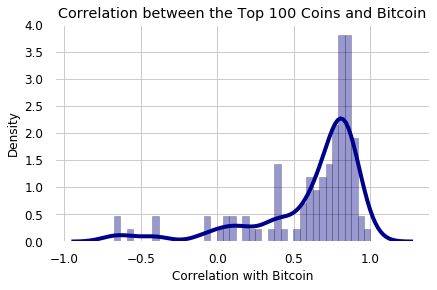

In [7]:
#---Step 6: Output Density Histogram Based on Correlation Coefficients---

#Correlations DF
corr_to_BTC = pd.DataFrame({'coins': df_dict_BTC}).sort_values('coins')

#Seaborn Distplot
ax = sns.distplot(corr_to_BTC['coins'], hist=True, kde=True, 
             bins=int(200/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

#Graph titles and axes labels
plt.title('Correlation between the Top 100 Coins and Bitcoin')
ax.set(xlabel='Correlation with Bitcoin', ylabel='Density')